In [2]:
import numpy as np
from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [5]:
class DecisionTreeEntropy:
    def __init__(self, max_depth=None, min_samples_split=2):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.tree = None
        self.feature_importances_ = None
    
    def entropy(self, y):
        """
        Compute the entropy for a given set of class labels.
        
        Parameters:
            y (np.array): Array of class labels.
        
        Returns:
            float: Entropy score.
        """
        _, counts = np.unique(y, return_counts=True)
        probabilities = counts / counts.sum()
        return -np.sum(probabilities * np.log2(probabilities + 1e-9))  # Avoid log(0)
    
    def best_split(self, X, y):
        """
        Determines the best feature and threshold for splitting the dataset.
        
        Parameters:
            X (np.array): Feature matrix.
            y (np.array): Target labels.
        
        Returns:
            tuple: (feature index, threshold) that results in the lowest weighted entropy.
        """
        best_entropy = float('inf')
        best_split = None
        m, n = X.shape
        
        for feature_idx in range(n):
            thresholds = np.unique(X[:, feature_idx])
            for threshold in thresholds:
                left_indices = X[:, feature_idx] <= threshold
                right_indices = ~left_indices
                
                if sum(left_indices) < self.min_samples_split or sum(right_indices) < self.min_samples_split:
                    continue
                
                left_entropy = self.entropy(y[left_indices])
                right_entropy = self.entropy(y[right_indices])
                weighted_entropy = (sum(left_indices) * left_entropy + sum(right_indices) * right_entropy) / m
                
                if weighted_entropy < best_entropy:
                    best_entropy = weighted_entropy
                    best_split = (feature_idx, threshold)
        
        return best_split
    
    def build_tree(self, X, y, depth=0, feature_importance=None):
        """
        Recursively builds the decision tree using the best feature splits.
        
        Stopping criteria:
        - If all samples belong to the same class, return that class.
        - If the maximum depth is reached, return the majority class.
        - If no valid split is found, return the majority class.
        
        Parameters:
            X (np.array): Feature matrix.
            y (np.array): Target labels.
            depth (int): Current depth of the tree.
            feature_importance (np.array or None): Tracks feature importance across splits.
        
        Returns:
            dict or int: A dictionary representing the tree structure, or a class label for leaf nodes.
            np.array: Updated feature importance scores.
        """
        if feature_importance is None:
            feature_importance = np.zeros(X.shape[1])  # Initialize importance array
        
        if len(np.unique(y)) == 1:
            return np.bincount(y).argmax(), feature_importance  # Return majority class
        
        if self.max_depth and depth >= self.max_depth:
            return np.bincount(y).argmax(), feature_importance
        
        split = self.best_split(X, y)
        if split is None:
            return np.bincount(y).argmax(), feature_importance
        
        feature_idx, threshold = split
        left_indices = X[:, feature_idx] <= threshold
        right_indices = ~left_indices

        # Compute impurity reduction
        parent_entropy = self.entropy(y)
        left_entropy = self.entropy(y[left_indices])
        right_entropy = self.entropy(y[right_indices])
        weighted_entropy = (sum(left_indices) * left_entropy + sum(right_indices) * right_entropy) / len(y)
        impurity_reduction = parent_entropy - weighted_entropy

        # Update feature importance
        feature_importance[feature_idx] += impurity_reduction

        # Recursively build left and right subtrees
        left_subtree, left_importance = self.build_tree(X[left_indices], y[left_indices], depth + 1, feature_importance.copy())
        right_subtree, right_importance = self.build_tree(X[right_indices], y[right_indices], depth + 1, feature_importance.copy())

        # Sum importance from both subtrees
        feature_importance = left_importance + right_importance

        return {
            'feature': feature_idx,
            'threshold': threshold,
            'left': left_subtree,
            'right': right_subtree
        }, feature_importance

    
    def fit(self, X, y):
        """
        Fits the decision tree classifier to the given dataset.
        
        Parameters:
            X (np.array): Feature matrix.
            y (np.array): Target labels.
        """
        self.tree, self.feature_importances_ = self.build_tree(X, y)
    
    def predict_sample(self, sample, node):
        """
        Predicts the class label for a single sample using the trained tree.
        
        Parameters:
            sample (np.array): A single data point.
            node (dict or int): Current node in the decision tree.
        
        Returns:
            int: Predicted class label.
        """
        if isinstance(node, dict):
            if sample[node['feature']] <= node['threshold']:
                return self.predict_sample(sample, node['left'])
            else:
                return self.predict_sample(sample, node['right'])
        return node
    
    def predict(self, X):
        """
        Predicts class labels for a dataset using the trained tree.
        
        Parameters:
            X (np.array): Feature matrix.
        
        Returns:
            np.array: Predicted class labels.
        """
        return np.array([self.predict_sample(sample, self.tree) for sample in X])
    
    def plot_feature_importance(self, feature_names=None):
        """
        Plots feature importance based on impurity reduction.
        """
        if self.feature_importances_ is None:
            raise ValueError("Model is not trained yet.")
        
        importance = self.feature_importances_ / np.sum(self.feature_importances_)
        
        plt.figure(figsize=(8, 5))
        if feature_names is None:
            feature_names = [f"Feature {i}" for i in range(len(importance))]
        plt.barh(feature_names, importance, color='skyblue')
        plt.xlabel("Feature Importance")
        plt.ylabel("Features")
        plt.title("Feature Importance (Entropy-Based Decision Tree)")
        plt.gca().invert_yaxis()
        plt.show()

In [6]:
iris = load_iris()
X, y = iris.data, iris.target
    
# Scale features
scaler = StandardScaler()
X = scaler.fit_transform(X)
    
# Split data
X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=242025
)
    
# Train model
model = DecisionTreeEntropy(
    max_depth=5
)
model.fit(X_train, y_train)
    
# Evaluate
y_pred = model.predict(X_test)
accuracy = np.mean(y_pred == y_test)
print(f"\nTest accuracy: {accuracy:.4f}")


Test accuracy: 0.9000


In [8]:
model.tree

{'feature': 2,
 'threshold': np.float64(-1.056039392054748),
 'left': np.int64(0),
 'right': {'feature': 2,
  'threshold': np.float64(0.5354085615261401),
  'left': {'feature': 0,
   'threshold': np.float64(-1.1430169111851116),
   'left': np.int64(1),
   'right': np.int64(1)},
  'right': {'feature': 3,
   'threshold': np.float64(0.659038469346772),
   'left': {'feature': 0,
    'threshold': np.float64(0.5533332750260058),
    'left': np.int64(2),
    'right': np.int64(1)},
   'right': np.int64(2)}}}

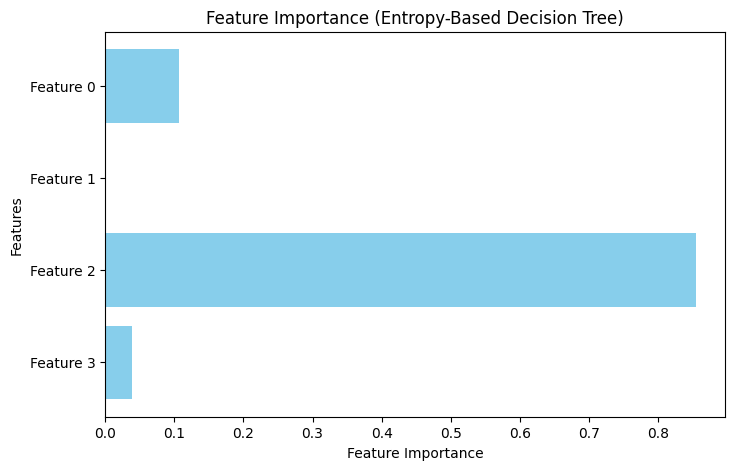

In [7]:
model.plot_feature_importance()